In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [3]:
# !pip install sweetviz --quiet


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os
import logging
import plotly
import plotly.express as px
import plotly.graph_objects as go
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import seaborn as sns
from scipy.stats import chi2_contingency, ks_2samp, skew, boxcox
import shap
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
# import sweetviz as sv
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, cv
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [8]:
train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
fed = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

In [9]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [10]:
test_data.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [12]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [13]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

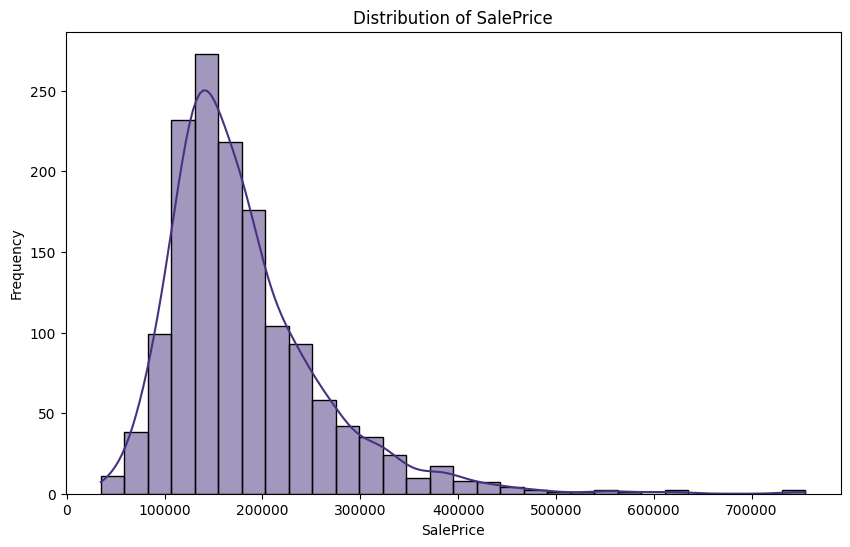

In [14]:
# Visualize the distribution of SalePrice
plt.figure(figsize=(10,6))
sns.histplot(train_data['SalePrice'], kde=True, bins=30, color=sns.color_palette("viridis")[0])
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

In [15]:
# Check Skewedness
skewness_value = skew(train_data['SalePrice'])

print(f"Skewness of SalePrice: {skewness_value}")

Skewness of SalePrice: 1.880940746034036


In [16]:
with open('/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt') as file:
    desc = file.read()
print(desc)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [17]:
# report = sv.analyze(train_data)

DFs sorted by DataType
TRAIN DATA

In [18]:
# Get columns sorted by dtype
sorted_columns = sorted(train_data.columns, key=lambda col: str(train_data[col].dtype))

# Reorder DataFrame columns based on sorted_columns
sorted_df = train_data[sorted_columns]

# Call info() on reordered DataFrame
sorted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1201 non-null   float64
 1   MasVnrArea     1452 non-null   float64
 2   GarageYrBlt    1379 non-null   float64
 3   Id             1460 non-null   int64  
 4   MSSubClass     1460 non-null   int64  
 5   LotArea        1460 non-null   int64  
 6   OverallQual    1460 non-null   int64  
 7   OverallCond    1460 non-null   int64  
 8   YearBuilt      1460 non-null   int64  
 9   YearRemodAdd   1460 non-null   int64  
 10  BsmtFinSF1     1460 non-null   int64  
 11  BsmtFinSF2     1460 non-null   int64  
 12  BsmtUnfSF      1460 non-null   int64  
 13  TotalBsmtSF    1460 non-null   int64  
 14  1stFlrSF       1460 non-null   int64  
 15  2ndFlrSF       1460 non-null   int64  
 16  LowQualFinSF   1460 non-null   int64  
 17  GrLivArea      1460 non-null   int64  
 18  BsmtFull

TEST DATA

In [19]:
# Get columns sorted by dtype
sorted_columns = sorted(test_data.columns, key=lambda col: str(train_data[col].dtype))

# Reorder DataFrame columns based on sorted_columns
sorted_df = train_data[sorted_columns]

# Call info() on reordered DataFrame
sorted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1201 non-null   float64
 1   MasVnrArea     1452 non-null   float64
 2   GarageYrBlt    1379 non-null   float64
 3   Id             1460 non-null   int64  
 4   MSSubClass     1460 non-null   int64  
 5   LotArea        1460 non-null   int64  
 6   OverallQual    1460 non-null   int64  
 7   OverallCond    1460 non-null   int64  
 8   YearBuilt      1460 non-null   int64  
 9   YearRemodAdd   1460 non-null   int64  
 10  BsmtFinSF1     1460 non-null   int64  
 11  BsmtFinSF2     1460 non-null   int64  
 12  BsmtUnfSF      1460 non-null   int64  
 13  TotalBsmtSF    1460 non-null   int64  
 14  1stFlrSF       1460 non-null   int64  
 15  2ndFlrSF       1460 non-null   int64  
 16  LowQualFinSF   1460 non-null   int64  
 17  GrLivArea      1460 non-null   int64  
 18  BsmtFull

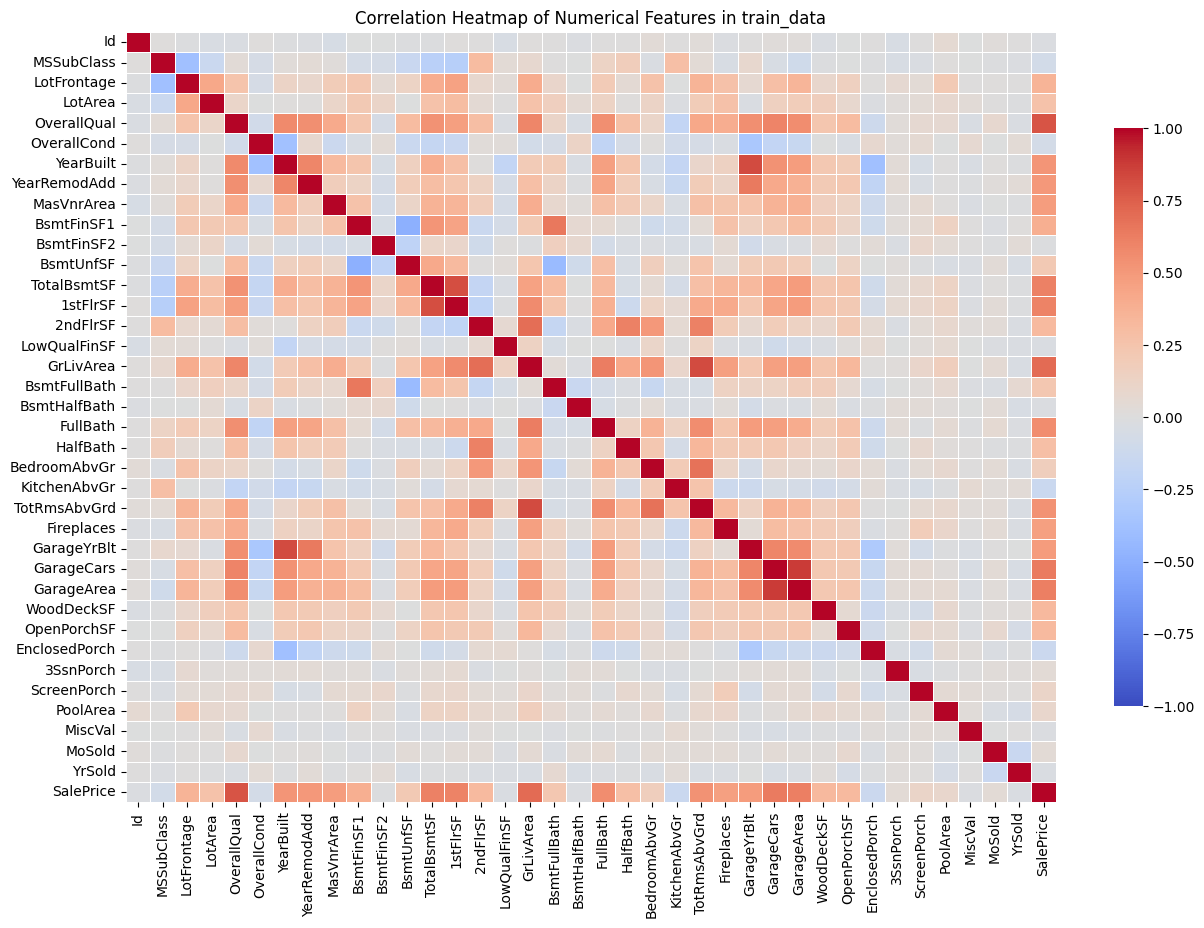

In [20]:
# Select only the numerical columns
numerical_data = train_data.select_dtypes(include=['number'])

# Compute the correlation matrix
corr = numerical_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Generate a heatmap
sns.heatmap(corr, cmap="coolwarm", vmax=1, vmin=-1, linewidths=.5, cbar_kws={"shrink": 0.75})

# Set the title
plt.title('Correlation Heatmap of Numerical Features in train_data')

# Save the plot as a high-definition PNG image
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


Check these hypotheses
Garage Area v. Garage Cars

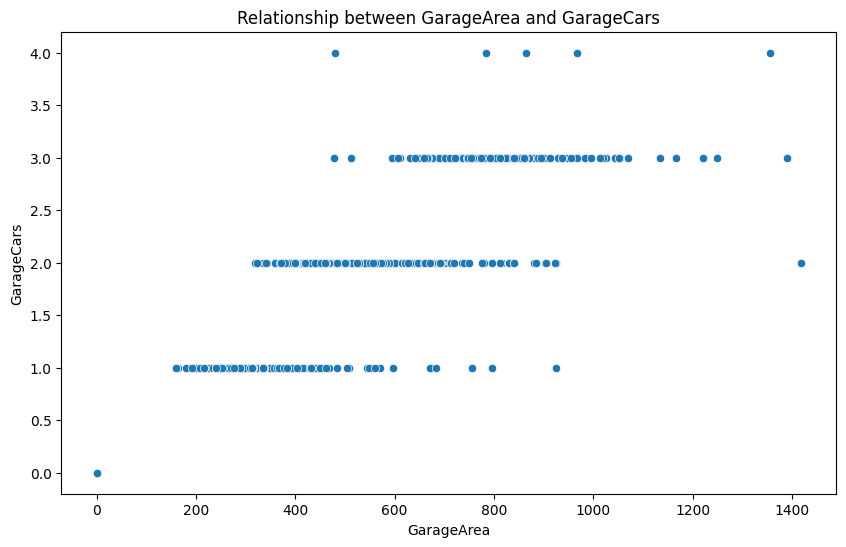

In [21]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x='GarageArea', y='GarageCars')
plt.title('Relationship between GarageArea and GarageCars')
plt.show()

In [22]:
correlation = train_data['GarageArea'].corr(train_data['GarageCars'])
print(f"Correlation between GarageArea and GarageCars: {correlation:.2f}")

Correlation between GarageArea and GarageCars: 0.88


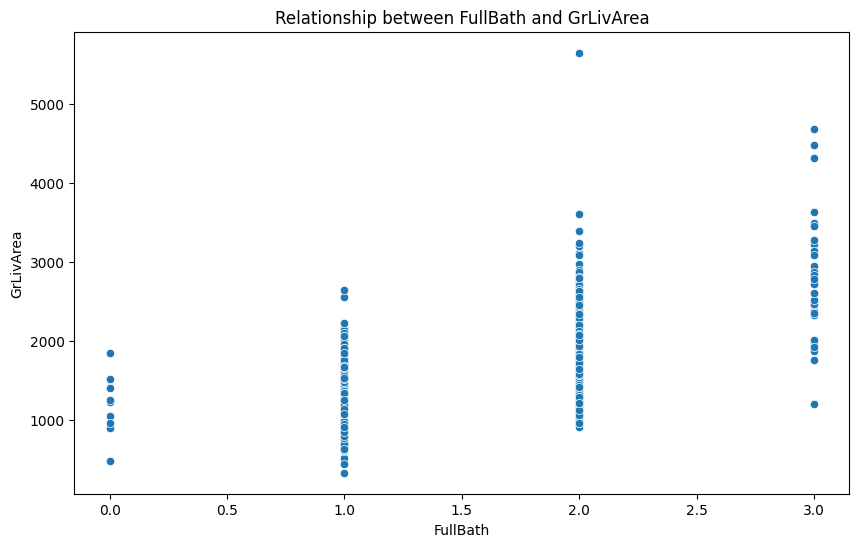

In [24]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x='FullBath', y='GrLivArea')
plt.title('Relationship between FullBath and GrLivArea')
plt.show()

In [25]:
correlation = train_data['FullBath'].corr(train_data['GrLivArea'])
print(f"Correlation between FullBath and GrLivArea: {correlation:.2f}")

Correlation between FullBath and GrLivArea: 0.63


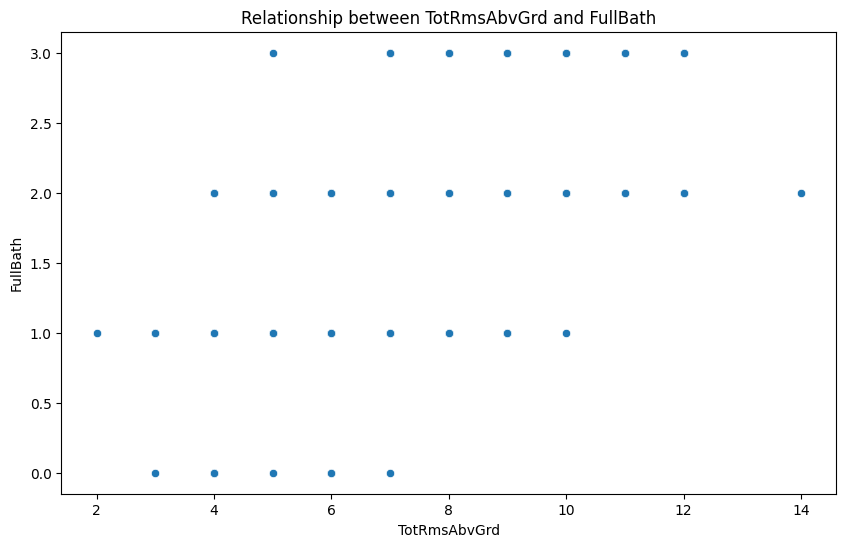

In [26]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x='TotRmsAbvGrd', y='FullBath')
plt.title('Relationship between TotRmsAbvGrd and FullBath')
plt.show()

In [27]:
correlation = train_data['TotRmsAbvGrd'].corr(train_data['GrLivArea'])
print(f"Correlation between TotRmsAbvGrd and FullBath: {correlation:.2f}")

Correlation between TotRmsAbvGrd and FullBath: 0.83


Adversarial Validation

In [28]:
# Drop the 'SalePrice' column from train_data
train_data_av = train_data.drop(['SalePrice','Id'], axis=1)
test_data_av = test_data.drop('Id', axis=1)

# Select only the numerical features
X_train = train_data_av.select_dtypes(include=['number']).copy()
X_test = test_data_av.select_dtypes(include=['number']).copy()

# Add the train/test labels
X_train["AV_label"] = 0
X_test["AV_label"] = 1

# Combine train and test data
all_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)

# Shuffle the combined dataset
all_data_shuffled = all_data.sample(frac=1)

# Create the DMatrix (XGBoost data structure)
X = all_data_shuffled.drop(['AV_label'], axis=1)
y = all_data_shuffled['AV_label']
XGBdata = xgb.DMatrix(data=X, label=y)

# Define XGBoost parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "learning_rate": 0.05,
    "max_depth": 5,
}

# Perform cross-validation with XGBoost
cross_val_results = cv(
    dtrain=XGBdata,
    params=params,
    nfold=5,
    metrics="auc",
    num_boost_round=200,
    early_stopping_rounds=20,
    as_pandas=True,
)

# Print out the final result
print((cross_val_results["test-auc-mean"]).tail(1))

16    0.5101
Name: test-auc-mean, dtype: float64


In [29]:
# Set the display options to show all rows. Doing this again for quicker reference.
pd.set_option('display.max_rows', None)

# Get the data types of each column
column_types = train_data.dtypes

# Sort the series by its values
sorted_column_types = column_types.sort_values()

# Display the sorted series
print(sorted_column_types)

Id                 int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
BsmtFinSF2         int64
BsmtFinSF1         int64
SalePrice          int64
MSSubClass         int64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
GarageYrBlt      float64
LotFrontage      float64
MasVnrArea       float64
Foundation        object
GarageFinish      object


In [31]:
# 'GarageYrBlt' should be an integer. 
# Let's change this prior to running adversarial data on numeric columns.

# Fill NaN values with 0 (or any other placeholder value)
train_data['GarageYrBlt'].fillna(0, inplace=True)
test_data['GarageYrBlt'].fillna(0, inplace=True)

# Convert 'GarageYrBlt' column to integer
train_data['GarageYrBlt'] = train_data['GarageYrBlt'].astype(int)
test_data['GarageYrBlt'] = test_data['GarageYrBlt'].astype(int)

Adversarial Validation with only numeric, non-ordinal, non-date columns

In [32]:
columns = [
    "2ndFlrSF", "GrLivArea", "TotRmsAbvGrd", "TotalBsmtSF", "LotArea",
    "BsmtUnfSF", "EnclosedPorch", "LotFrontage", "Fireplaces", "BsmtFinSF1",
    "GarageArea", "GarageCars", "MasVnrArea", "1stFlrSF", "OverallQual",
    "OpenPorchSF", "ScreenPorch", "BedroomAbvGr", "WoodDeckSF", 
    "OverallCond", "BsmtFinSF2"
]

train_data_av = train_data[columns].copy()
test_data_av = test_data[columns].copy()

# Select only the numerical features
X_train = train_data_av.select_dtypes(include=['number']).copy()
X_test = train_data_av.select_dtypes(include=['number']).copy()

# Add the train/test labels
X_train["AV_label"] = 0
X_test["AV_label"] = 1

# Combine train and test data
all_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)

# Shuffle the combined dataset
all_data_shuffled = all_data.sample(frac=1)

# Create the DMatrix (XGBoost data structure)
X = all_data_shuffled.drop(['AV_label'], axis=1)
y = all_data_shuffled['AV_label']
XGBdata = xgb.DMatrix(data=X, label=y)

# Define XGBoost parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "learning_rate": 0.05,
    "max_depth": 5,
}

# Perform cross-validation with XGBoost
cross_val_results = cv(
    dtrain=XGBdata,
    params=params,
    nfold=5,
    metrics="auc",
    num_boost_round=200,
    early_stopping_rounds=20,
    as_pandas=True,
)

# Print out the final result
print((cross_val_results["test-auc-mean"]).tail(1))

0    0.344004
Name: test-auc-mean, dtype: float64


Chi Squared for categorical + ordinal features

In [33]:
catord = [
    "MSSubClass", "Electrical", "MSZoning", "Street", "Alley", "LotConfig", 
    "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", 
    "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", 
    "Foundation", "Heating", "Utilities", "BsmtFinType1", "BsmtFinType2", 
    "Functional", "GarageType", "SaleType", 'LotShape','LandContour','LandSlope',
    'ExterQual','ExterCond','HeatingQC','CentralAir','PavedDrive','PoolQC',
    'Fence','MiscFeature','SaleCondition',
    "OverallCond", "BedroomAbvGr", "OverallQual", 
    "GarageCars", "Fireplaces", "TotRmsAbvGrd", 
    "KitchenAbvGr", "BsmtFullBath", "BsmtHalfBath", 
    "FullBath", "HalfBath",
    "GarageFinish", "BsmtExposure", "BsmtCond", "KitchenQual", 
    "FireplaceQu", "BsmtQual", "GarageQual", "GarageCond", 
    "LotShape", "LandContour", "Utilities", "LandSlope", 
    "BsmtFinType1", "BsmtFinType2", "Functional"
]

results = {}

for feature in catord:
    # Get unique values from both train and test data for the feature
    unique_values = pd.concat([train_data[feature], test_data[feature]]).dropna().unique()
    
    # Construct a contingency table
    contingency_table_train = train_data[feature].value_counts().reindex(unique_values).fillna(0)
    contingency_table_test = test_data[feature].value_counts().reindex(unique_values).fillna(0)
    
    # Concatenate both series to get a 2D dataframe
    contingency_table = pd.concat([contingency_table_train, contingency_table_test], axis=1)
    
    # Chi-squared test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Store the result
    results[feature] = p

# Sort p-values in descending order
sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

# Print p-values
for feature, p_value in sorted_results.items():
    print(f"{feature}: P-value = {p_value:.5f}")

Street: P-value = 1.00000
Utilities: P-value = 1.00000
Condition1: P-value = 0.92123
HalfBath: P-value = 0.91902
HeatingQC: P-value = 0.91853
Exterior1st: P-value = 0.89473
GarageCond: P-value = 0.88632
BldgType: P-value = 0.84976
Foundation: P-value = 0.77599
SaleType: P-value = 0.76867
Electrical: P-value = 0.76820
MiscFeature: P-value = 0.75060
MSSubClass: P-value = 0.73905
CentralAir: P-value = 0.70785
SaleCondition: P-value = 0.70145
BsmtHalfBath: P-value = 0.67841
LotShape: P-value = 0.67837
ExterQual: P-value = 0.65894
MasVnrType: P-value = 0.64533
BsmtFullBath: P-value = 0.63172
KitchenQual: P-value = 0.62755
Condition2: P-value = 0.62621
Exterior2nd: P-value = 0.62182
RoofStyle: P-value = 0.55554
BsmtExposure: P-value = 0.55171
Functional: P-value = 0.50789
KitchenAbvGr: P-value = 0.50469
FireplaceQu: P-value = 0.49219
Fireplaces: P-value = 0.46621
OverallCond: P-value = 0.44648
BsmtCond: P-value = 0.44382
PoolQC: P-value = 0.43460
BsmtFinType1: P-value = 0.39337
GarageFinish:

View Categorical and Ordinal Distributions

In [ ]:
# Set the style for better visualization
sns.set_style('whitegrid')

# Loop through each column in the catord list
for col in catord:
    # Create a subplot
    plt.figure(figsize=(15, 6))
    
    # Plot for train_data
    plt.subplot(1, 2, 1)
    sns.countplot(data=train_data, x=col, order=train_data[col].value_counts().index, color=sns.color_palette("viridis")[0])
    plt.title(f'Train Data Distribution of {col}')
    plt.xticks(rotation=90)
    
    # Plot for test_data
    plt.subplot(1, 2, 2)
    sns.countplot(data=test_data, x=col, order=test_data[col].value_counts().index, color=sns.color_palette("viridis")[1])
    plt.title(f'Test Data Distribution of {col}')
    plt.xticks(rotation=90)
    
    # Display the plot
    plt.tight_layout()
    plt.show()

Komogorov-Smirnov Test for continous features
This compares the distribution of two datasets

In [ ]:
# List of columns to test
columns = [
    "GrLivArea", "GarageCars", "Fireplaces", "TotRmsAbvGrd", "BsmtFinSF1", 
    "KitchenAbvGr", "BsmtFinSF2", "BsmtUnfSF", "BedroomAbvGr",
    "HalfBath", "FullBath", "BsmtHalfBath", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
    "TotalBsmtSF", "GarageArea", "OverallQual", "MSSubClass",
     "LotArea", "MiscVal", "PoolArea", "ScreenPorch", "3SsnPorch",
    "OverallCond", "EnclosedPorch", "BsmtFullBath", "OpenPorchSF", "WoodDeckSF",
    "MasVnrArea", "LotFrontage"
]

# Compute the K-S test for each column
results = {}
for column in columns:
    statistic, p_value = ks_2samp(train_data[column].dropna(), test_data[column].dropna())
    results[column] = (statistic, p_value)

# Convert results dictionary into a DataFrame
results_df = pd.DataFrame(results).T  
results_df.columns = ["Statistic", "P-value"]

# Sort the results by P-value in descending order
sorted_results_df = results_df.sort_values(by='P-value', ascending=False)
print(sorted_results_df)